In [1]:
from collections import Counter
import numpy as np
import nltk
import re
import sklearn.manifold
import multiprocessing
import pandas as pd
import gensim.models.word2vec as w2v

d:\dev\python\mlacourse\venv\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
data = pd.read_csv(r'D:\codebase\notebooks\course_tasks\sommelier\sommelier_train_clear_v2.csv')
data = data.groupby("super clear variety").filter(lambda x: len(x) >100)
data["super clear variety"].value_counts()

red blend                        12709
blauer arbst                      8156
chardonnay                        7969
cabernet sauvignon                7363
shiraz                            4299
sauvignon blanc                   3493
white blend                       3417
brunello                          3175
crouchen                          3135
merlot                            2788
zinfandel                         2256
sparkling blend                   1780
malbec                            1730
rose blend                        1659
aragónez                          1633
canari noir                       1500
nebbiolo                          1164
corvina, rondinella, molinara      970
cabernet franc                     766
viognier                           738
champagne blend                    711
fortified blend                    684
grüner veltliner                   614
gewürztraminer                     599
barbera                            595
cabernet sauvignon blend 

In [3]:
labels = data['super clear variety']
descriptions = data['Description']
labels.value_counts()

red blend                        12709
blauer arbst                      8156
chardonnay                        7969
cabernet sauvignon                7363
shiraz                            4299
sauvignon blanc                   3493
white blend                       3417
brunello                          3175
crouchen                          3135
merlot                            2788
zinfandel                         2256
sparkling blend                   1780
malbec                            1730
rose blend                        1659
aragónez                          1633
canari noir                       1500
nebbiolo                          1164
corvina, rondinella, molinara      970
cabernet franc                     766
viognier                           738
champagne blend                    711
fortified blend                    684
grüner veltliner                   614
gewürztraminer                     599
barbera                            595
cabernet sauvignon blend 

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler

ohe = OneHotEncoder(sparse=False)
vectorizer = TfidfVectorizer(stop_words='english')

X = vectorizer.fit_transform(data['Description'])
y = labels.values.reshape(-1,1)

rus = TomekLinks(random_state=0)
X, y = rus.fit_resample(X, y)

y_labels = ohe.fit_transform(y.reshape(-1,1))


print(X.shape)
print(y.shape)

(79935, 28093)
(79935,)


In [ ]:
pd.DataFrame(y)[0].value_counts()

In [6]:
# Получение обучающих и валидационных выборок для кросс-валидации
from sklearn.model_selection import StratifiedKFold, KFold

# Функция для построения графика изменения значений ошибки
def loss_graph(epochs, train_loss, val_loss):
    x_axis = np.linspace(1, epochs, num=epochs)
    
    plt.figure(figsize=(10, 7))
    plt.plot(x_axis, train_loss, color='b', lw=3, alpha=0.7, label='Train Loss')
    plt.plot(x_axis, val_loss, color='r', lw=3, alpha=0.7, label='Val Loss')
    plt.title('Loss graph')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    
# Функция для построеняи графика изменения значений метрики Accuracy
def acc_graph(epochs, train_acc, val_acc):
    x_axis = np.linspace(1, epochs, num=epochs)
    
    plt.figure(figsize=(10, 7))
    plt.plot(x_axis, train_acc, color='g', lw=3, alpha=0.7, label='Train Accuracy')
    plt.plot(x_axis, val_acc, color='orange', lw=3, alpha=0.7, label='Val Accuracy')
    plt.title('Accuracy graph')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    
def train_validate_nn(model_getter, X, y, folds_num = 2, epochs_num = 500):
    
    kf = StratifiedKFold(n_splits=folds_num, shuffle=True)
    X_trains, X_vals, y_trains, y_vals = [], [], [], []
    for train_idx, val_idx in kf.split(X, ohe.inverse_transform(y)):
        X_trains.append(X[train_idx])
        X_vals.append(X[val_idx])
        y_trains.append(y[train_idx])
        y_vals.append(y[val_idx])
    
    train_loss = np.zeros((folds_num, epochs_num))
    val_loss = np.zeros((folds_num, epochs_num))
    train_acc = np.zeros((folds_num, epochs_num))
    val_acc = np.zeros((folds_num, epochs_num))

    model_index = 0
    for i in range(len(X_trains)):
        model = model_getter()
        print('Model num ',model_index)
        model_index = model_index + 1
        log = model.fit(X_trains[i], y_trains[i], epochs=epochs_num, validation_data=(X_vals[i], y_vals[i]), shuffle=True,\
                 batch_size=16, verbose=1)
        train_loss[i] = log.history.get('loss')
        val_loss[i] = log.history.get('val_loss')
        train_acc[i] = log.history.get('acc')
        val_acc[i] = log.history.get('val_acc')
    
    train_loss_mean = train_loss.mean(axis=0).ravel()
    val_loss_mean = val_loss.mean(axis=0).ravel()
    train_acc_mean = train_acc.mean(axis=0).ravel()
    val_acc_mean = val_acc.mean(axis=0).ravel()
    return train_loss_mean, val_loss_mean, train_acc_mean, val_acc_mean

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Flatten
from keras.regularizers import l2

l2_lambda = 0.0001

def get_model():
    model = Sequential()
    model.add(Dense(128,input_shape=(28093,), activation='relu',init='he_uniform' ))
    model.add(Dense(128, activation='relu', init='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', init='he_uniform'))
    model.add(Dense(53, activation='softmax', init='glorot_uniform'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



epochs_num = 10
train_loss_mean, val_loss_mean, train_acc_mean, val_acc_mean = train_validate_nn(get_model, X, y_labels, epochs_num=epochs_num, folds_num=2)


Using TensorFlow backend.
d:\dev\python\mlacourse\venv\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, input_shape=(28093,), activation="relu", kernel_initializer="he_uniform")`
  if __name__ == '__main__':
d:\dev\python\mlacourse\venv\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="he_uniform")`
  # Remove the CWD from sys.path while we load stuff.
d:\dev\python\mlacourse\venv\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="he_uniform")`
  if sys.path[0] == '':
d:\dev\python\mlacourse\venv\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(53, activation="softmax", kernel_initializer="glorot_uniform")`
  del sys.path[0]


Model num  0
Train on 39952 samples, validate on 39983 samples
Epoch 1/10
39952/39952 [==============================] - 368s 9ms/step - loss: 1.8219 - acc: 0.5086 - val_loss: 1.3435 - val_acc: 0.6265
Epoch 2/10
39952/39952 [==============================] - 368s 9ms/step - loss: 0.9966 - acc: 0.7190 - val_loss: 1.2984 - val_acc: 0.6403
Epoch 3/10
39952/39952 [==============================] - 368s 9ms/step - loss: 0.6188 - acc: 0.8199 - val_loss: 1.4648 - val_acc: 0.6274
Epoch 4/10
39952/39952 [==============================] - 367s 9ms/step - loss: 0.3742 - acc: 0.8879 - val_loss: 1.7220 - val_acc: 0.6234
Epoch 5/10
39952/39952 [==============================] - 373s 9ms/step - loss: 0.2181 - acc: 0.9350 - val_loss: 2.1002 - val_acc: 0.6166
Epoch 6/10
39952/39952 [==============================] - 377s 9ms/step - loss: 0.1268 - acc: 0.9608 - val_loss: 2.4572 - val_acc: 0.6073
Epoch 7/10
39952/39952 [==============================] - 386s 10ms/step - loss: 0.0804 - acc: 0.9748 - val_l

In [8]:
get_model().summary()

d:\dev\python\mlacourse\venv\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, input_shape=(28093,), activation="relu", kernel_initializer="he_uniform")`
  if __name__ == '__main__':
d:\dev\python\mlacourse\venv\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="he_uniform")`
  # Remove the CWD from sys.path while we load stuff.
d:\dev\python\mlacourse\venv\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="he_uniform")`
  if sys.path[0] == '':
d:\dev\python\mlacourse\venv\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(53, activation="softmax", kernel_initializer="glorot_uniform")`
  del sys.path[0]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               3596032   
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 53)                3445      
Total params: 3,624,245
Trainable params: 3,624,245
Non-trainable params: 0
_________________________________________________________________


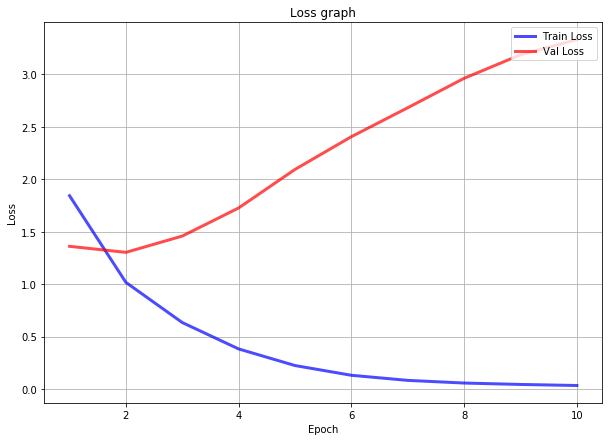

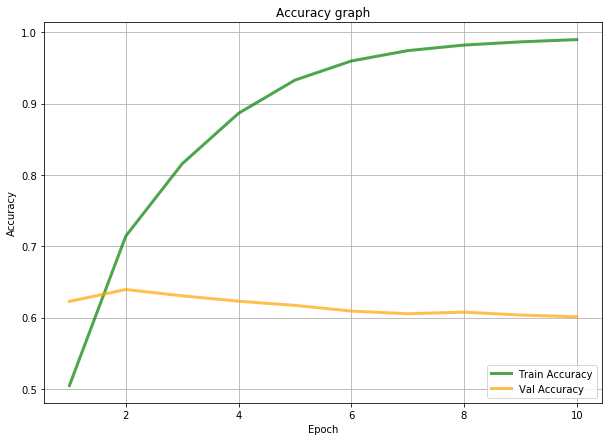

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

loss_graph(epochs_num, train_loss_mean, val_loss_mean)
acc_graph(epochs_num, train_acc_mean, val_acc_mean)

In [19]:
model = get_model()

log = model.fit(X, y_labels, epochs=8, shuffle=True, batch_size=16, verbose=1)

yp = model.predict(X)
model.save_weights('nn128x128.hd5')

d:\dev\python\mlacourse\venv\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, input_shape=(28093,), activation="relu", kernel_initializer="he_uniform")`
  if __name__ == '__main__':
d:\dev\python\mlacourse\venv\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="he_uniform")`
  # Remove the CWD from sys.path while we load stuff.
d:\dev\python\mlacourse\venv\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="he_uniform")`
  if sys.path[0] == '':
d:\dev\python\mlacourse\venv\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(53, activation="softmax", kernel_initializer="glorot_uniform")`
  del sys.path[0]


Epoch 1/8
79935/79935 [==============================] - 689s 9ms/step - loss: 1.5605 - acc: 0.5735
Epoch 2/8
79935/79935 [==============================] - 685s 9ms/step - loss: 0.9378 - acc: 0.7304
Epoch 3/8
79935/79935 [==============================] - 685s 9ms/step - loss: 0.6442 - acc: 0.8092
Epoch 4/8
79935/79935 [==============================] - 688s 9ms/step - loss: 0.4299 - acc: 0.8701
Epoch 5/8
79935/79935 [==============================] - 686s 9ms/step - loss: 0.2821 - acc: 0.9141
Epoch 6/8
79935/79935 [==============================] - 685s 9ms/step - loss: 0.1858 - acc: 0.9422
Epoch 7/8
79935/79935 [==============================] - 701s 9ms/step - loss: 0.1302 - acc: 0.9590
Epoch 8/8
79935/79935 [==============================] - 699s 9ms/step - loss: 0.0964 - acc: 0.9694


In [20]:
from sklearn.metrics import accuracy_score

def undec(soft_vals):
    result = np.zeros_like(soft_vals)
    result[np.arange(len(soft_vals)), soft_vals.argmax(1)] = 1
    return result

yp = undec(yp)

accuracy_score(y, ohe.inverse_transform(yp))

0.9931319196847439

In [21]:
uniqs  = list(data['super clear variety'].unique())
results_pred = ohe.inverse_transform(yp)
results = y

frame = pd.DataFrame(results, columns=['super clear variety'])
frame['Pred'] = results_pred
total_cnt = frame.groupby(by='super clear variety').count().to_dict()['Pred']

result = {}
for v in uniqs:
    cnt = total_cnt[v]
    buf = frame[frame['super clear variety'] == v]['Pred'].value_counts()
    result[v] = buf[v] / cnt
    print(v, ' TOTAL: ',cnt, 'TRUE: ', buf[v], 'PERCENT: ', buf[v] / cnt)

red blend  TOTAL:  12576 TRUE:  12513 PERCENT:  0.9949904580152672
blauer arbst  TOTAL:  8088 TRUE:  8039 PERCENT:  0.9939416419386746
tempranillo blend  TOTAL:  423 TRUE:  409 PERCENT:  0.966903073286052
cabernet sauvignon  TOTAL:  7281 TRUE:  7257 PERCENT:  0.9967037494849609
zinfandel  TOTAL:  2204 TRUE:  2193 PERCENT:  0.9950090744101633
aragónez  TOTAL:  1628 TRUE:  1614 PERCENT:  0.9914004914004914
verdejo  TOTAL:  177 TRUE:  175 PERCENT:  0.9887005649717514
chardonnay  TOTAL:  7899 TRUE:  7879 PERCENT:  0.9974680339283454
canari noir  TOTAL:  1475 TRUE:  1463 PERCENT:  0.991864406779661
sauvignon blanc  TOTAL:  3458 TRUE:  3441 PERCENT:  0.9950838635049162
gamay  TOTAL:  313 TRUE:  312 PERCENT:  0.9968051118210862
white blend  TOTAL:  3352 TRUE:  3310 PERCENT:  0.9874701670644391
albariño  TOTAL:  354 TRUE:  350 PERCENT:  0.9887005649717514
merlot  TOTAL:  2730 TRUE:  2714 PERCENT:  0.9941391941391942
torrontés  TOTAL:  195 TRUE:  194 PERCENT:  0.9948717948717949
shiraz  TOTAL: 

In [22]:
import operator
sorted_x = sorted(result.items(), key=operator.itemgetter(1))
sorted_x

[('zweigelt', 0.8803418803418803),
 ('touriga nacional', 0.9423076923076923),
 ('pinot blanc', 0.9473684210526315),
 ('shiraz blend', 0.9631901840490797),
 ('blaufränkisch', 0.9655172413793104),
 ('tempranillo blend', 0.966903073286052),
 ('vermentino', 0.9682539682539683),
 ('chenin blanc', 0.9768637532133676),
 ('cabernet sauvignon blend', 0.9779411764705882),
 ('durif', 0.9796747967479674),
 ('garnatxa', 0.9826086956521739),
 ('garganega', 0.9838709677419355),
 ('malbec', 0.9842748980780431),
 ('mourvèdre', 0.984375),
 ('petit verdot', 0.9844961240310077),
 ('viognier', 0.9862448418156808),
 ('grüner veltliner', 0.9867330016583747),
 ('white blend', 0.9874701670644391),
 ('verdejo', 0.9887005649717514),
 ('albariño', 0.9887005649717514),
 ('champagne blend', 0.9900709219858156),
 ('furmint', 0.9900990099009901),
 ('mencía', 0.9903846153846154),
 ('fortified blend', 0.9911504424778761),
 ('pinotage', 0.9912280701754386),
 ('aragónez', 0.9914004914004914),
 ('canari noir', 0.991864406

<BarContainer object of 53 artists>

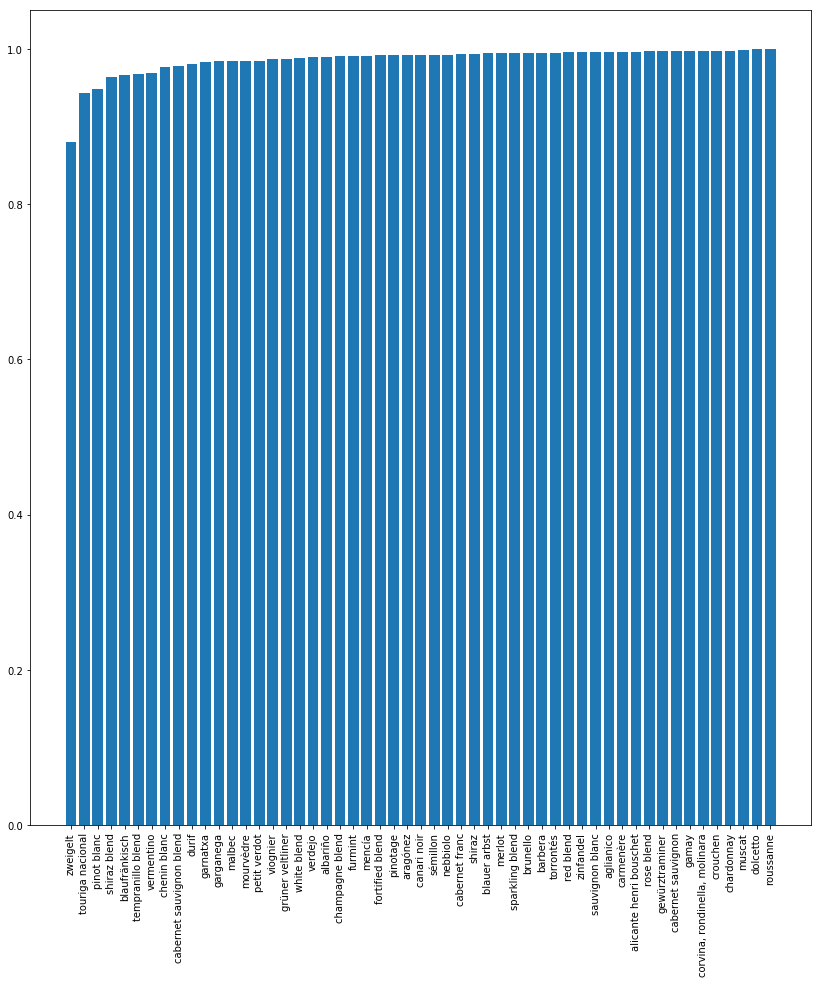

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline



r = pd.DataFrame(sorted_x, columns=['Name', 'Acc'])
plt.figure(figsize=(14,15))
plt.xticks(rotation=90)
plt.bar(r['Name'], r['Acc'])

In [24]:
data_test = pd.read_csv(r'D:\codebase\notebooks\course_tasks\sommelier\sommelier_test_clear_v2.csv')
known_classses = list(data['super clear variety'].unique())
data_test = data_test[data_test["super clear variety"].isin(known_classses)]

labels_test = data_test['super clear variety']
descriptions_test = data_test['Description']


X_test = vectorizer.transform(descriptions_test)
y_test = ohe.transform(labels_test.values.reshape(-1,1))




y_test_pred = model.predict(X_test)
accuracy_score(labels_test, ohe.inverse_transform(y_test_pred))

0.8188342509967723

In [25]:
uniqs  = list(data_test['super clear variety'].unique())
results_pred = ohe.inverse_transform(y_test_pred)
results = labels_test

frame = pd.DataFrame(results)
frame['Pred'] = results_pred
total_cnt = frame.groupby(by='super clear variety').count().to_dict()['Pred']

result = {}
for v in uniqs:
    cnt = total_cnt[v]
    buf = frame[frame['super clear variety'] == v]['Pred'].value_counts()
    result[v] = buf[v] / cnt
    print(v, ' TOTAL: ',cnt, 'TRUE: ', buf[v], 'PERCENT: ', buf[v] / cnt)

shiraz  TOTAL:  1435 TRUE:  1157 PERCENT:  0.8062717770034843
cabernet sauvignon  TOTAL:  2382 TRUE:  1946 PERCENT:  0.81696053736356
grüner veltliner  TOTAL:  198 TRUE:  143 PERCENT:  0.7222222222222222
brunello  TOTAL:  1032 TRUE:  873 PERCENT:  0.8459302325581395
red blend  TOTAL:  4054 TRUE:  3467 PERCENT:  0.8552047360631475
barbera  TOTAL:  234 TRUE:  208 PERCENT:  0.8888888888888888
chardonnay  TOTAL:  2630 TRUE:  2379 PERCENT:  0.9045627376425855
merlot  TOTAL:  917 TRUE:  704 PERCENT:  0.7677208287895311
sauvignon blanc  TOTAL:  1149 TRUE:  960 PERCENT:  0.835509138381201
blauer arbst  TOTAL:  2646 TRUE:  2266 PERCENT:  0.8563869992441421
crouchen  TOTAL:  1001 TRUE:  871 PERCENT:  0.8701298701298701
malbec  TOTAL:  565 TRUE:  416 PERCENT:  0.736283185840708
zinfandel  TOTAL:  746 TRUE:  618 PERCENT:  0.8284182305630027
white blend  TOTAL:  1093 TRUE:  866 PERCENT:  0.7923147301006405
cabernet franc  TOTAL:  249 TRUE:  167 PERCENT:  0.6706827309236948
sparkling blend  TOTAL:  

In [26]:
import operator
sorted_x = sorted(result.items(), key=operator.itemgetter(1))
sorted_x

[('mencía', 0.4827586206896552),
 ('pinot blanc', 0.5609756097560976),
 ('tempranillo blend', 0.5639097744360902),
 ('zweigelt', 0.575),
 ('garnatxa', 0.5901639344262295),
 ('cabernet sauvignon blend', 0.5978260869565217),
 ('touriga nacional', 0.6),
 ('petit verdot', 0.6),
 ('pinotage', 0.6),
 ('mourvèdre', 0.6071428571428571),
 ('roussanne', 0.6206896551724138),
 ('shiraz blend', 0.65),
 ('gamay', 0.6530612244897959),
 ('blaufränkisch', 0.6666666666666666),
 ('cabernet franc', 0.6706827309236948),
 ('sémillon', 0.6842105263157895),
 ('verdejo', 0.6851851851851852),
 ('viognier', 0.6916299559471366),
 ('alicante henri bouschet', 0.7),
 ('chenin blanc', 0.7028985507246377),
 ('aglianico', 0.7096774193548387),
 ('durif', 0.7108433734939759),
 ('grüner veltliner', 0.7222222222222222),
 ('gewürztraminer', 0.7277486910994765),
 ('carmenère', 0.7304964539007093),
 ('aragónez', 0.7327102803738318),
 ('malbec', 0.736283185840708),
 ('albariño', 0.7610619469026548),
 ('canari noir', 0.76326530

<BarContainer object of 53 artists>

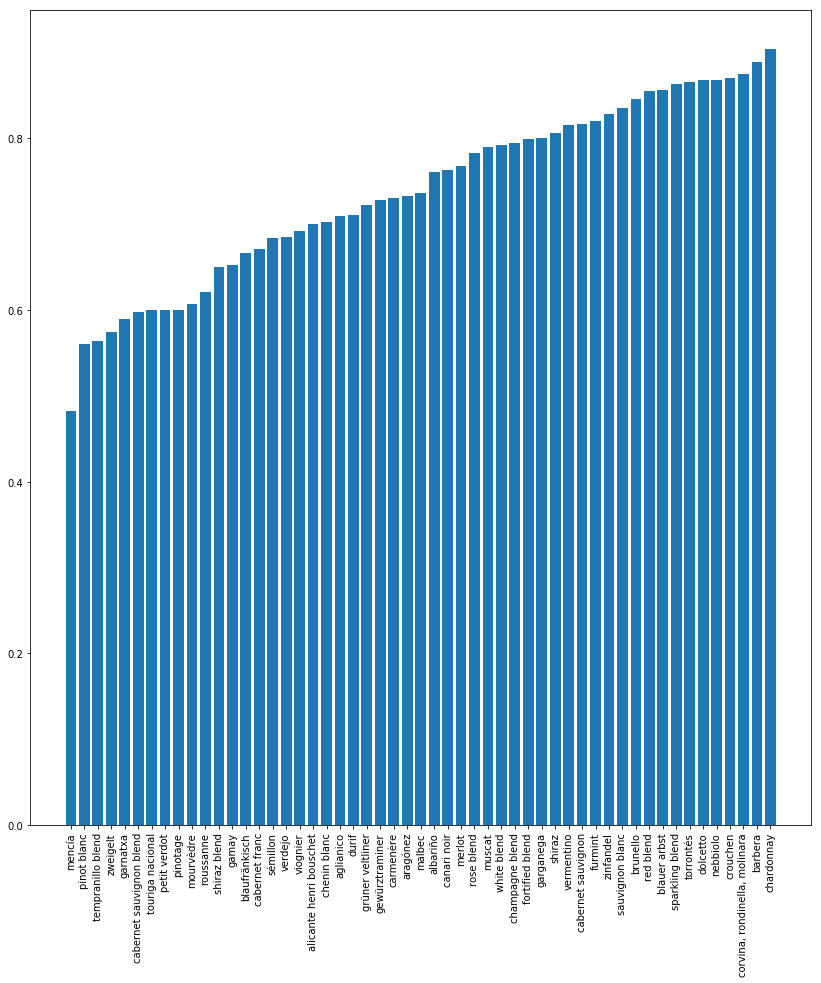

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline



r = pd.DataFrame(sorted_x, columns=['Name', 'Acc'])
plt.figure(figsize=(14,15))
plt.xticks(rotation=90)
plt.bar(r['Name'], r['Acc'])